# Demand Sensing on Instacart Dataset using Ensemble Models

## Project Goal
Predict product reorder likelihood using the Instacart Online Grocery Basket dataset. This project uses ensemble models and includes exhaustive feature engineering, model interpretation with SHAP, and business insights.


Step 1: Importing Packages and Datasets

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# File system & display
import os
pd.set_option('display.max_columns', None)

#Model Implementation with Undersampling and Ensembles
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

#Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#SHAP
import shap

#Customer segmentation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Load all CSVs
orders = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\orders.csv')
products = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\products.csv')
order_products_prior = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\order_products__prior.csv')
order_products_train = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\order_products__train.csv')
aisles = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\aisles.csv')
departments = pd.read_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\departments.csv')

Step 2: Initial Exploratory Data Analysis (EDA)

In [4]:
# Dataset dimensions
print("Orders:", orders.shape)
print("Products:", products.shape)
print("Order Products (Prior):", order_products_prior.shape)
print("Order Products (Train):", order_products_train.shape)
print("Aisles:", aisles.shape)
print("Departments:", departments.shape)

Orders: (3421083, 7)
Products: (49688, 4)
Order Products (Prior): (32434489, 4)
Order Products (Train): (1384617, 4)
Aisles: (134, 2)
Departments: (21, 2)


In [5]:
# Display first few rows
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
# Missing values check
for name, df in zip(
    ['orders', 'products', 'order_products_prior', 'order_products_train', 'aisles', 'departments'],
    [orders, products, order_products_prior, order_products_train, aisles, departments]
):
    print(f"{name} missing values:\n{df.isnull().sum()}\n")

orders missing values:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

products missing values:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

order_products_prior missing values:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

order_products_train missing values:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

aisles missing values:
aisle_id    0
aisle       0
dtype: int64

departments missing values:
department_id    0
department       0
dtype: int64



In [9]:
#Order Statistics
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [10]:
# Overall reorder rate
reorder_rate = order_products_prior['reordered'].mean()
print(f"Overall reorder rate: {reorder_rate:.2f}")

Overall reorder rate: 0.59


In [11]:
print("Unique users:", orders['user_id'].nunique())
print("Unique products:", products['product_id'].nunique())
print("Unique aisles:", aisles['aisle_id'].nunique())
print("Unique departments:", departments['department_id'].nunique())

Unique users: 206209
Unique products: 49688
Unique aisles: 134
Unique departments: 21


Step 3: Data Cleaning

Objective
Ensure all datasets are clean and ready for merging and feature engineering:

- Remove irrelevant columns
- Handle missing or incorrect values
- Optimize datatypes
- Prepare for merging

In [12]:
# Check for missing values
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [44]:
# Convert days_since_prior_order to 0 for first order (NaN → 0)
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(np.int8)

# Optimize dtypes
orders['order_dow'] = orders['order_dow'].astype(np.int8)
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype(np.int8)
orders['order_number'] = orders['order_number'].astype(np.int16)
orders['user_id'] = orders['user_id'].astype(np.int32)
orders['order_id'] = orders['order_id'].astype(np.int32)

In [14]:
# Check for missing values
order_products_prior.isnull().sum()
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [15]:
# Optimize data types for memory efficiency
for df in [order_products_prior, order_products_train]:
    df['add_to_cart_order'] = df['add_to_cart_order'].astype(np.int16)
    df['reordered'] = df['reordered'].astype(np.int8)
    df['product_id'] = df['product_id'].astype(np.int32)
    df['order_id'] = df['order_id'].astype(np.int32)

In [16]:
# Merge product metadata
product_details = products.merge(aisles, on='aisle_id', how='left') \
                          .merge(departments, on='department_id', how='left')

# Clean column names
product_details.rename(columns={
    'aisle': 'aisle_name',
    'department': 'department_name'
}, inplace=True)

# Optimize
product_details['aisle_id'] = product_details['aisle_id'].astype(np.int8)
product_details['department_id'] = product_details['department_id'].astype(np.int8)
product_details['product_id'] = product_details['product_id'].astype(np.int32)

Step 4: Visual Exploratory Data Analysis (EDA)

Objective
Visualize behavioral trends of users and products to:

- Understand ordering patterns
- Reveal seasonality or time effects
- Spot which features might be important for predicting reorders

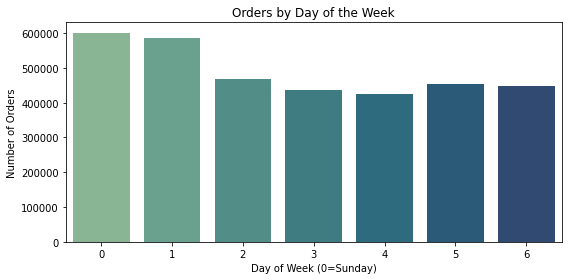

In [17]:
#Orders by Day of Week
plt.figure(figsize=(8,4))
sns.countplot(data=orders, x='order_dow', palette='crest')
plt.title('Orders by Day of the Week')
plt.xlabel('Day of Week (0=Sunday)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

Insight: Ordering spikes on days 0 and 1 — indicating weekend grocery habits.

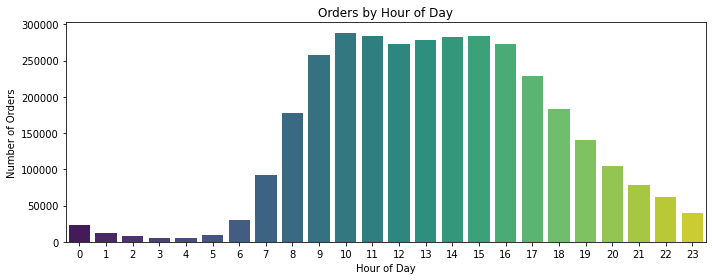

In [18]:
#Orders by Hour of Day
plt.figure(figsize=(10,4))
sns.countplot(data=orders, x='order_hour_of_day', palette='viridis')
plt.title('Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

Insight: Most orders are placed between 8 AM and 5 PM — likely related to working hours or availability.

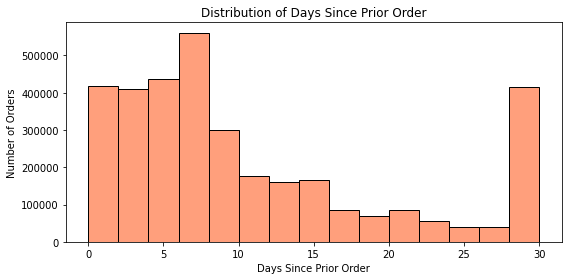

In [19]:
#Days Since Prior Order Distribution
plt.figure(figsize=(8,4))
sns.histplot(orders['days_since_prior_order'], bins=15, kde=False, color='coral')
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

Insight: Peaks at day 7 and 30 — showing strong weekly and monthly ordering cycles.

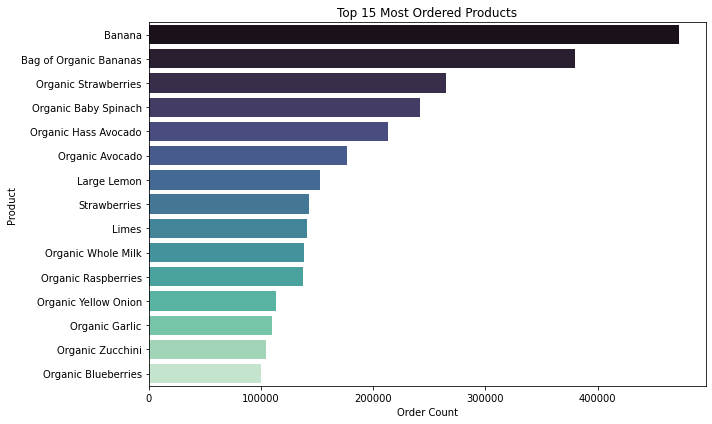

In [20]:
#Top 15 Most Ordered Products
top_products = order_products_prior['product_id'].value_counts().head(15).reset_index()
top_products.columns = ['product_id', 'order_count']
top_products = top_products.merge(products, on='product_id')

plt.figure(figsize=(10,6))
sns.barplot(data=top_products, y='product_name', x='order_count', palette='mako')
plt.title('Top 15 Most Ordered Products')
plt.xlabel('Order Count')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

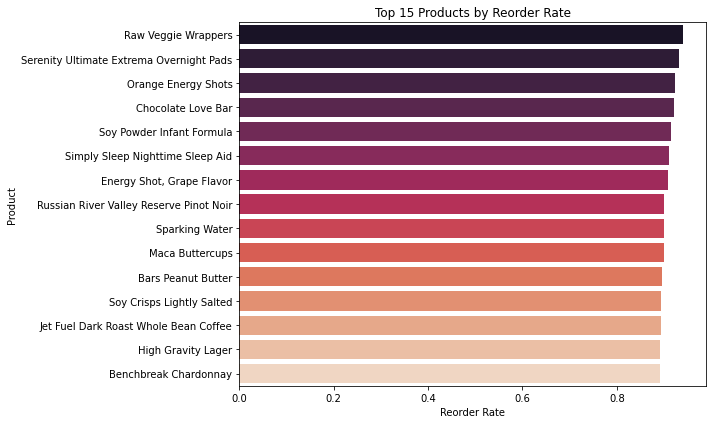

In [21]:
#Reorder Rate by Product
reorder_ratio = order_products_prior.groupby('product_id')['reordered'].mean().reset_index()
reorder_ratio.columns = ['product_id', 'reorder_rate']
top_reordered = reorder_ratio.merge(products, on='product_id') \
                             .sort_values(by='reorder_rate', ascending=False) \
                             .head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_reordered, x='reorder_rate', y='product_name', palette='rocket')
plt.title('Top 15 Products by Reorder Rate')
plt.xlabel('Reorder Rate')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

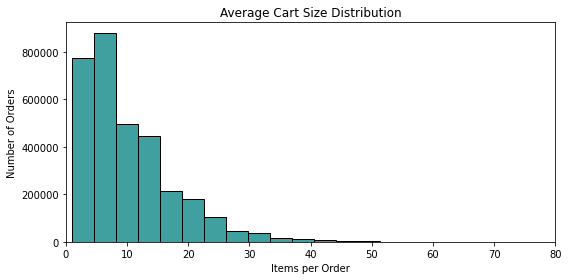

In [22]:
# Average Cart Size per User
cart_sizes = order_products_prior.groupby('order_id').size()
plt.figure(figsize=(8,4))
sns.histplot(cart_sizes, bins=40, kde=False, color='teal')
plt.title('Average Cart Size Distribution')
plt.xlabel('Items per Order')
plt.ylabel('Number of Orders')
plt.xlim(0, 80)
plt.tight_layout()
plt.show()

Insight: Most baskets have <20 items. Outliers with 50+ could be worth exploring for fraud or bulk behavior.

Step 5: Exhaustive Feature Engineering
Objective
Build rich, predictive features from:

- User behavior
- Product statistics
- User-Product interactions

In [23]:
# Merge order + prior product details
prior = order_products_prior.merge(orders, on='order_id', how='left')
prior = prior.merge(product_details, on='product_id', how='left')

In [24]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle_name,department_name
0,2,33120,1,1,202279,prior,3,5,9,8,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8,Natural Sweetener,17,13,baking ingredients,pantry


In [45]:
# USER-LEVEL FEATURES
#Aggregate Behavior for Each User
user_features = prior.groupby('user_id').agg({
    'order_number': 'max',  # Total orders
    'days_since_prior_order': ['mean', 'std'],  # Avg ordering cycle
    'order_id': 'nunique'  # Unique orders
}).reset_index()

user_features.columns = ['user_id', 'total_orders', 'avg_days_between_orders', 'std_days_between_orders', 'unique_orders']

In [26]:
#User reorder ratio
reorders = prior.groupby('user_id')['reordered'].agg(['sum', 'count']).reset_index()
reorders.columns = ['user_id', 'total_reordered', 'total_products']
reorders['user_reorder_ratio'] = reorders['total_reordered'] / reorders['total_products']

# Merge into user features
user_features = user_features.merge(reorders[['user_id', 'user_reorder_ratio']], on='user_id')

In [27]:
user_features.head()

,user_id,total_orders,avg_days_between_orders,std_days_between_orders,unique_orders,user_reorder_ratio
0,1,10,18.542373,10.559065,10,0.694915
1,2,14,14.902564,9.671712,14,0.476923
2,3,12,10.181818,5.867396,12,0.625000
3,4,5,11.944444,9.973330,5,0.055556
4,5,4,10.189189,7.600577,4,0.378378


In [28]:
#PRODUCT-LEVEL FEATURES
#Aggregate Behavior for Each User
product_features = prior.groupby('product_id').agg({
    'reordered': ['sum', 'count', 'mean'],
    'add_to_cart_order': 'mean'
}).reset_index()

product_features.columns = ['product_id', 'total_reorders', 'total_orders', 'reorder_rate', 'avg_cart_position']

In [29]:
#USER-PRODUCT INTERACTION FEATURES
#Reordering the same product frequency
user_product = prior.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count',  # times product was purchased
    'add_to_cart_order': 'mean',
    'order_number': ['min', 'max']
}).reset_index()

user_product.columns = ['user_id', 'product_id', 'up_order_count', 'up_avg_cart_position', 'up_first_order_num', 'up_last_order_num']

In [30]:
#Add reordering flags
up_reorders = prior.groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()
up_reorders.columns = ['user_id', 'product_id', 'up_reorder_total']

user_product = user_product.merge(up_reorders, on=['user_id', 'product_id'], how='left')
user_product['up_reorder_ratio'] = user_product['up_reorder_total'] / user_product['up_order_count']

In [31]:
#Final Feature Assembly for Train Set
# Get the latest order for each user in the train set
train_orders = orders[orders['eval_set'] == 'train'][['user_id', 'order_id']]

# Merge user_id + product_id features with latest train order
train_data = train_orders.merge(user_product, on='user_id')
train_data = train_data.merge(user_features, on='user_id')
train_data = train_data.merge(product_features, on='product_id')

In [32]:
# Add target variable: whether the product was reordered in this train order
labels = order_products_train[['order_id', 'product_id', 'reordered']]
train_data = train_data.merge(labels, on=['order_id', 'product_id'], how='left')
train_data['reordered'] = train_data['reordered'].fillna(0).astype(np.int8)

In [33]:
#train_data.to_csv('C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\instacart_train_features.csv', index=False)

Step 6: Modeling with Undersampling

In [34]:
# Load engineered features dataset
df = pd.read_csv("C:\\Users\\princ\\Downloads\\Demand Sensing\\Instacart_dataset\\instacart_train_features.csv")

# Prepare features and target
X = df.drop(columns=['order_id', 'user_id', 'product_id', 'reordered'])
y = df['reordered']

In [35]:
df.head()

,user_id,order_id,product_id,up_order_count,up_avg_cart_position,up_first_order_num,up_last_order_num,up_reorder_total,up_reorder_ratio,total_orders_x,avg_days_between_orders,std_days_between_orders,unique_orders,user_reorder_ratio,total_reorders,total_orders_y,reorder_rate,avg_cart_position,reordered
0,1,1187899,196,10,1.400000,1,10,9,0.900000,10,18.542373,10.559065,10,0.694915,27791.0,35791,0.77648,3.721774,1
1,21,1854765,196,1,2.000000,10,10,0,0.000000,33,9.809756,7.389573,33,0.502439,27791.0,35791,0.77648,3.721774,0
2,43,1864787,196,2,5.000000,6,9,1,0.500000,11,10.190476,6.075251,11,0.401361,27791.0,35791,0.77648,3.721774,0
3,52,1647290,196,14,4.285714,1,21,13,0.928571,27,8.810651,4.918346,27,0.698225,27791.0,35791,0.77648,3.721774,0
4,67,2757217,196,19,1.421053,1,23,18,0.947368,24,7.333333,3.748333,24,0.716049,27791.0,35791,0.77648,3.721774,1


In [36]:
# Combine X and y for resampling
data = pd.concat([X, y], axis=1)

In [37]:
# Separate minority and majority classes
minority = data[data['reordered'] == 1]
majority = data[data['reordered'] == 0]

In [38]:
# Undersample majority class
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)


In [39]:
# Create balanced dataset
balanced_data = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=42).reset_index(drop=True)

In [40]:
# Split into features and labels
X_balanced = balanced_data.drop('reordered', axis=1)
y_balanced = balanced_data['reordered']

In [41]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [42]:
# Base Models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=500, random_state=42)

In [92]:
# Train and evaluate Random Forest
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.4f}\n")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75    248741
           1       0.75      0.74      0.74    248554

    accuracy                           0.75    497295
   macro avg       0.75      0.75      0.75    497295
weighted avg       0.75      0.75      0.75    497295

Random Forest ROC AUC: 0.8220



In [93]:
# Train and evaluate XGBoost
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print(f"XGBoost ROC AUC: {roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]):.4f}\n")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75    248741
           1       0.75      0.76      0.75    248554

    accuracy                           0.75    497295
   macro avg       0.75      0.75      0.75    497295
weighted avg       0.75      0.75      0.75    497295

XGBoost ROC AUC: 0.8291



In [94]:
# Train and evaluate Logistic Regression
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.4f}\n")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73    248741
           1       0.73      0.76      0.74    248554

    accuracy                           0.74    497295
   macro avg       0.74      0.74      0.74    497295
weighted avg       0.74      0.74      0.74    497295

Logistic Regression ROC AUC: 0.8102



Hyperparameter Tuning

In [95]:
# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_tune = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_tune.fit(X_train, y_train)
print("Best XGBoost params:", xgb_tune.best_params_)
print(f"Best XGBoost CV F1 score: {xgb_tune.best_score_:.4f}")

# Evaluate best model
best_xgb = xgb_tune.best_estimator_
xgb_preds = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.6}
Best XGBoost CV F1 score: 0.7523
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75    248741
           1       0.75      0.76      0.75    248554

    accuracy                           0.75    497295
   macro avg       0.75      0.75      0.75    497295
weighted avg       0.75      0.75      0.75    497295



In [97]:
# Define grid for logistic regression (limited options)
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

lr_tune = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=500, random_state=42),
    param_distributions=lr_param_grid,
    n_iter=10,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lr_tune.fit(X_train, y_train)
print("Best Logistic Regression params:", lr_tune.best_params_)
print(f"Best Logistic Regression CV F1 score: {lr_tune.best_score_:.4f}")

# Evaluate best model
best_lr = lr_tune.best_estimator_
lr_preds = best_lr.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
Best Logistic Regression CV F1 score: 0.7458
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73    248741
           1       0.72      0.76      0.74    248554

    accuracy                           0.74    497295
   macro avg       0.74      0.74      0.74    497295
weighted avg       0.74      0.74      0.74    497295



Step 7: Result Comparison & Visualization

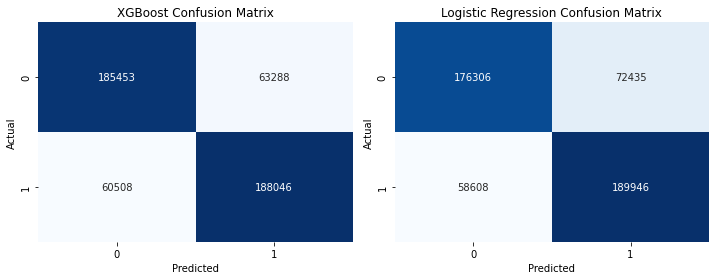

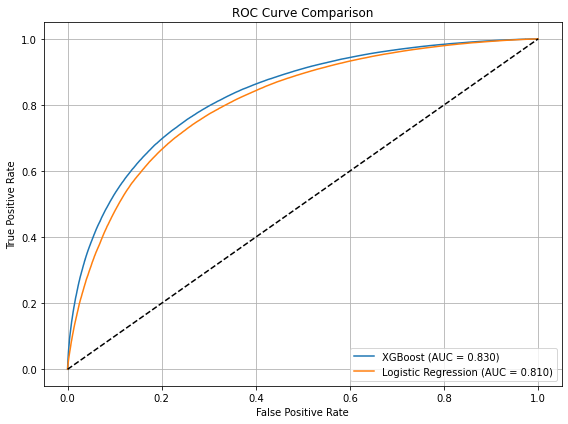

,Model,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.748,0.757,0.752,0.83
1,Logistic Regression,0.724,0.764,0.744,0.81


In [99]:
# Model dictionary
models = {
    "XGBoost": best_xgb,
    "Logistic Regression": best_lr
}

# Store metrics for comparison
model_metrics = []

# Plot Confusion Matrices
plt.figure(figsize=(15, 4))
for i, (name, model) in enumerate(models.items()):
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Collect and print model comparison metrics
for name, model in models.items():
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc_score = roc_auc_score(y_test, probs)

    model_metrics.append({
        'Model': name,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'ROC AUC': round(auc_score, 3)
    })

# Display as DataFrame
metrics_df = pd.DataFrame(model_metrics)
display(metrics_df.sort_values(by='F1 Score', ascending=False))

Customer Segmentation

In [48]:
prior_merged = order_products_prior.merge(orders, on='order_id', how='left')

In [49]:
user_features = prior_merged.groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean',
    'reordered': 'mean',
    'product_id': 'nunique'
}).rename(columns={
    'order_number': 'total_orders',
    'days_since_prior_order': 'avg_days_between_orders',
    'reordered': 'reorder_ratio',
    'product_id': 'unique_products_ordered'
}).reset_index()

In [50]:
# Drop user_id for clustering
features = user_features.drop('user_id', axis=1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

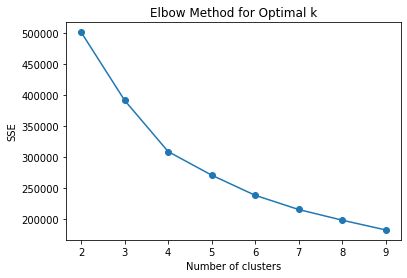

In [51]:
# Use elbow method to decide k
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Fit KMeans with chosen k (say k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
user_features['segment'] = kmeans.fit_predict(X_scaled)

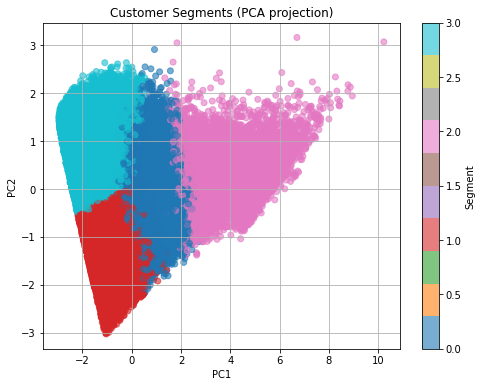

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_features['segment'], cmap='tab10', alpha=0.6)
plt.title('Customer Segments (PCA projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Segment')
plt.grid(True)
plt.show()